# Exploración de datos

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
from functools import reduce
import copy
from collections import OrderedDict

project_path = os.path.abspath('../..')
sys.path.insert(1, project_path)

import pandas as pd
import numpy as np
import xarray as xr
from scipy.stats import circmean

import matplotlib.pyplot as plt
import datashader as ds
import datashader.transfer_functions as tf
import seaborn as sns
sns.set(style="darkgrid")

from src.utils import get_project_root
from src.data.make_dataset import get_minma_data
from src.visualization.trends import visualizar_trends
from src.visualization.eda import *

## EDA

In [4]:
params = ['SO2','NO2', 'NO', 'NOX', 'O3']
from_last = '5y'

### Carga de datos 

In [5]:
data_df = get_minma_data(params, 'ventanas', from_last=from_last)
data_df = data_df.filter(regex=("Registros no validados_"))
data_df.columns = data_df.columns.str.strip('Registros no validados_')

meteo_df = pd.read_excel(get_project_root() / 'data' / 'raw' / 'Torre Meteo Codelco Ventanas.xlsx').set_index('date')
meteo_df['T_diff'] = meteo_df['T_40'] - meteo_df['T_20']

cems_df = pd.read_excel(get_project_root() / 'data' / 'raw' / 'CEMS industrial datos Quintero.xlsx', index_col=0, skiprows=2)

/home/agonzalez/projects/mds7201-minma-so2/src/data/make_dataset.py:62: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  from_date = to_date - pd.Timedelta(from_last)


In [6]:
data_df = pd.merge(meteo_df[['T_diff', 'T_20', 'HR_20', 'P_20']], data_df, left_index=True, right_index=True)
data_df = pd.merge(cems_df, data_df, left_index=True, right_index=True)
data_df.head()

,CEMS U1 Ventanas,CEMS U2 Ventanas,CEMS U3 Ventanas,CEMS U4 Ventanas,CEMS Chimenea Codelco,CEMS Planta Acido Codelco,T_diff,T_20,HR_20,P_20,SO2,NO2,NO,NOX,O3
2019-08-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,-1.01881,10.09780,59.6488,1020.00,67.74,14.91,30.08960,45.00330,7.0
2019-08-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,-1.04118,9.47633,62.3453,1020.02,18.57,5.86,3.61533,9.47153,14.0
2019-08-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,-1.09232,8.97534,64.6565,1020.00,34.01,13.76,14.94080,28.70360,9.0
2019-08-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,-0.99535,8.67967,65.4817,1020.00,47.94,15.70,18.47960,34.17880,6.0
2019-08-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,-0.89680,8.86282,63.6508,1020.00,16.85,11.37,11.64560,23.01360,11.0


### Conteo de peaks

In [7]:
def get_SO2_peaks(df, SO2_col, peak_level):
    SO2_daily = np.array([g for n, g in df[SO2_col].groupby(pd.Grouper(freq='D')) if not g.empty], dtype=object)
    peak_mask = [(day_df > peak_level).any() for day_df in SO2_daily]
    peak_days = [day.index[0].date() for day in SO2_daily[peak_mask]]
    return SO2_daily[peak_mask], peak_days

def get_SO2_limit(df, SO2_col, peak_level):
    SO2_daily = np.array([g for n, g in df[SO2_col].groupby(pd.Grouper(freq='D')) if not g.empty], dtype=object)
    peak_mask = [(day_df > peak_level).any() == False for day_df in SO2_daily]
    peak_days = [day.index[0].date() for day in SO2_daily[peak_mask]]
    return SO2_daily[peak_mask], peak_days

def filter_by_dates(df, date_list, output_format='list'):
    filtered_dates = [df.loc[date.strftime('%Y-%m-%d')] for date in date_list]
    if output_format == 'list':
        return filtered_dates
    elif output_format == 'DataFrame':
        return pd.concat(filtered_dates)

def dates_to_hours(df_list):
    daily_df = copy.deepcopy(df_list)
    for df in daily_df:
        df.index = df.index.hour
    return daily_df

In [8]:
_, peak_days = get_SO2_peaks(data_df, 'SO2', 130)
data_peaks_df = filter_by_dates(data_df, peak_days)

In [9]:
_, limit_days = get_SO2_limit(data_df, 'SO2', 100)
data_limit50_df = filter_by_dates(data_df, limit_days)

In [10]:
data_peaks_df = dates_to_hours(data_peaks_df)
data_limit50_df = dates_to_hours(data_limit50_df)

## Datashader

In [ ]:
qwe = pd.DataFrame(asd).T
qwe.columns = np.arange(1, qwe.shape[1]+1)
qwe = qwe.add_prefix('SO2_')
qwe['Time'] = np.arange(1,25)
cols = qwe.columns[:-1]

In [ ]:
# Default plot ranges:
x_range = (qwe.iloc[0].Time, qwe.iloc[-1].Time)
y_range = (qwe.min().min(), qwe.max().max())

print("x_range: {0} y_range: {1}".format(x_range,y_range))

x_range: (1.0, 24.0) y_range: (0.31, 480.25)


In [ ]:
cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=300, plot_width=900)
aggs = OrderedDict((c, cvs.line(qwe, 'Time', c)) for c in cols)
# img = tf.shade(aggs['a'])

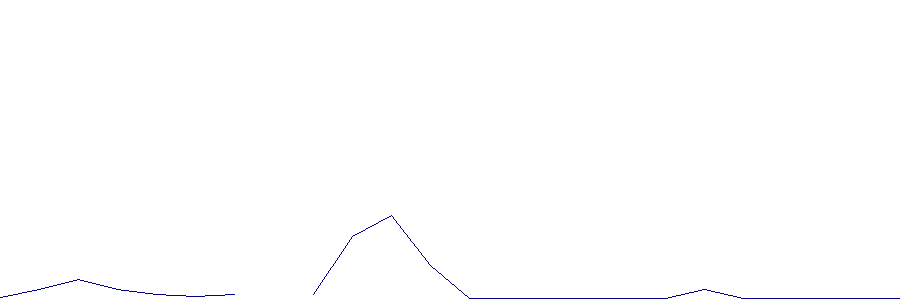

In [ ]:
tf.shade(aggs['SO2_120'])

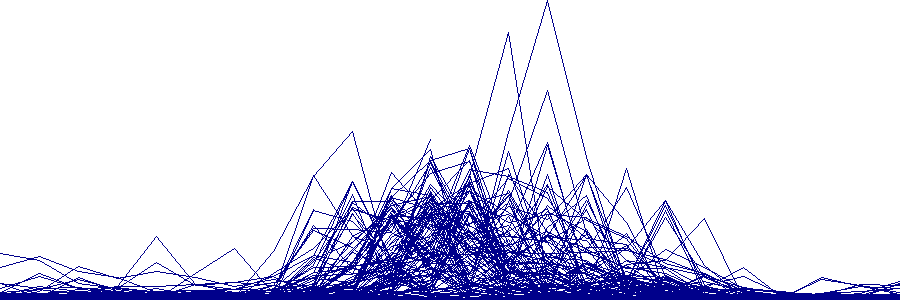

In [ ]:
renamed = [aggs[key].rename({key: 'value'}) for key in aggs]
merged = xr.concat(renamed, 'cols')
tf.shade(merged.any(dim='cols'))

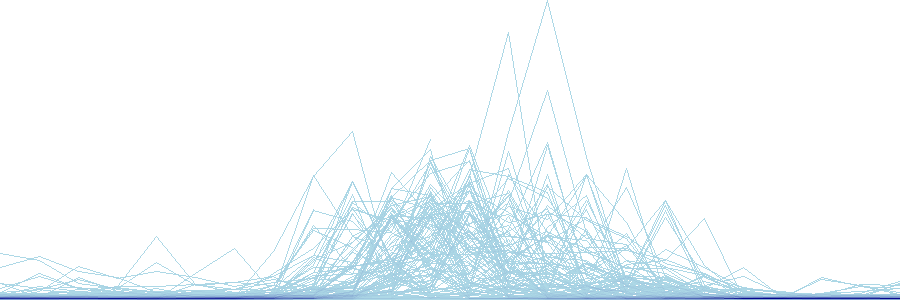

In [ ]:
total = tf.shade(merged.sum(dim='cols').astype('uint32'), how='linear')
total

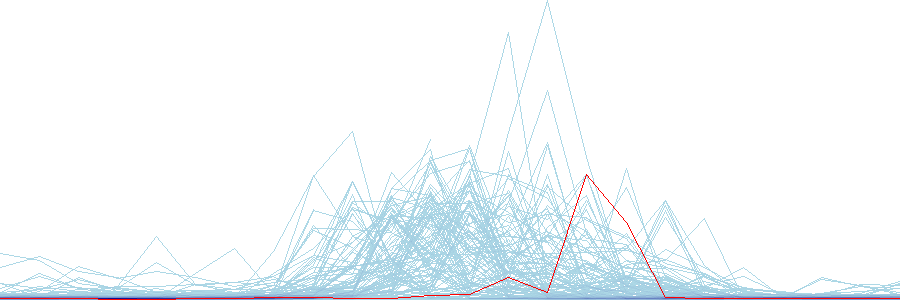

In [ ]:
tf.stack(total, tf.shade(aggs['SO2_32'], cmap=["lightblue", "red"]))

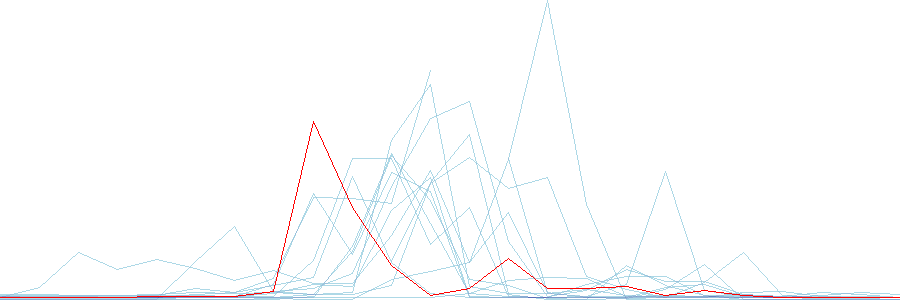

In [ ]:
tf.stack(total, tf.shade(aggs['SO2_7'], cmap=["lightblue", "red"]))


## Manual overview

### Plots

In [ ]:
for idx in range(5):
    fig, ax = plt.subplots(3,3,figsize=(20,10),sharex=True)

    data_peaks_df[idx].diff().plot(subplots=True, ax=ax, marker='o')
    fig.suptitle(f'Maitenes analysis on peak day -> {peak_days[idx]}', fontsize=16)
    plt.tight_layout()
    plt.show()

### Daily comparison

In [11]:
def daily_stats(df_list_daily):
    return np.array([df.describe().loc[['min', 'max', 'mean', 'std']].values for df in df_list_daily])

def plot_temp(df_daily, df_daily2=None, figsize=(20,50)):
    metrics = ['min', 'max', 'mean', 'std']
    columns = df_daily[0].columns
    n_cols = columns.shape[0]
    stats_daily = daily_stats(df_daily)
    stats_daily2 = daily_stats(df_daily2)

    fig = plt.figure(constrained_layout=True, figsize=figsize)
    # fig.suptitle('Figure title')

    # create 3x1 subfigs
    subfigs = fig.subfigures(nrows=n_cols, ncols=1)
    for row, subfig in enumerate(subfigs):
        subfig.suptitle('- '*20 + f' {columns[row]} ' + '- '*20 , fontsize=16)

        # create 1x3 subplots per subfig
        axs = subfig.subplots(nrows=1, ncols=len(metrics))
        for col, ax in enumerate(axs):
            ax.hist(stats_daily[:, col, row], alpha=0.5, density=True, bins=30)
            ax.hist(stats_daily2[:, col, row], alpha=0.5, density=True, bins=30)
            ax.legend(['Peak days', 'Normal days'])
            ax.set_xlabel(metrics[col])

# ------------------------------------------------------------------------------
    # fig, axes = plt.subplots(n_cols, len(metrics), figsize=(20,30))
    # for idx, ax in enumerate(axes.ravel()):
    #     ax.hist(stats_daily[:,idx % len(metrics), idx // len(metrics)], alpha=0.5, density=True)
    #     ax.set_ylabel('count')
    #     ax.set_xlabel(metrics[idx % len(metrics)])
    #     ax.set_title(f'{columns[idx // len(metrics)]}')

    # if df_daily2 != None:
    #     stats_daily = np.array([df.describe().loc[metrics].values for df in df_daily2])
    #     for idx, ax in enumerate(axes.ravel()):
    #         ax.hist(stats_daily[:,idx % len(metrics), idx // len(metrics)], alpha=0.5, density=True)
    #         ax.set_title(f'{columns[idx // len(metrics)]}')
    #         ax.legend(['Peak days', 'Normal days'])

    # plt.tight_layout()
    plt.show()

In [12]:
print(f'N° peaks: {len(data_peaks_df)} - N° "normal" days: {len(data_limit50_df)}')

N° peaks: 1 - N° "normal" days: 1152


In [ ]:
fig, axes = plt.subplots(data_limit50_df[0].columns.shape[0], 2, figsize=(20,50))

n = 100
rand_normal_days = np.random.choice(data_limit50_df, n)

for df in rand_normal_days:
    df.plot(ax=axes[:,0], subplots=True)

for df in data_peaks_df:
    df.plot(ax=axes[:,1], subplots=True)

for idx, ax in enumerate(axes.ravel()):
    ax.legend([data_peaks_df[0].columns[idx // 2]])

axes[0,0].set_title('Días sin peaks', fontsize=20)
axes[0,1].set_title('Días con peaks', fontsize=20)
plt.show()

In [ ]:
plot_temp(data_peaks_df, data_limit50_df)

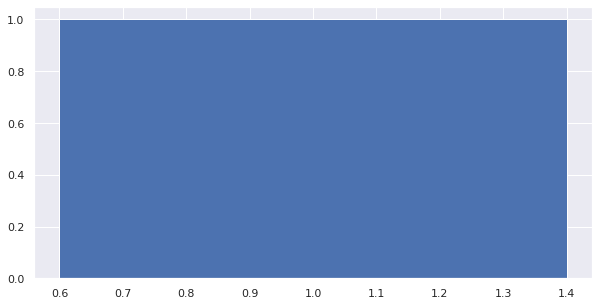

In [19]:
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(*np.unique(list(map(lambda x: x.weekday(), peak_days)), return_counts=True))

plt.show()

### Visualización inicial

/home/agonzalez/miniconda3/envs/mds7202/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/agonzalez/miniconda3/envs/mds7202/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


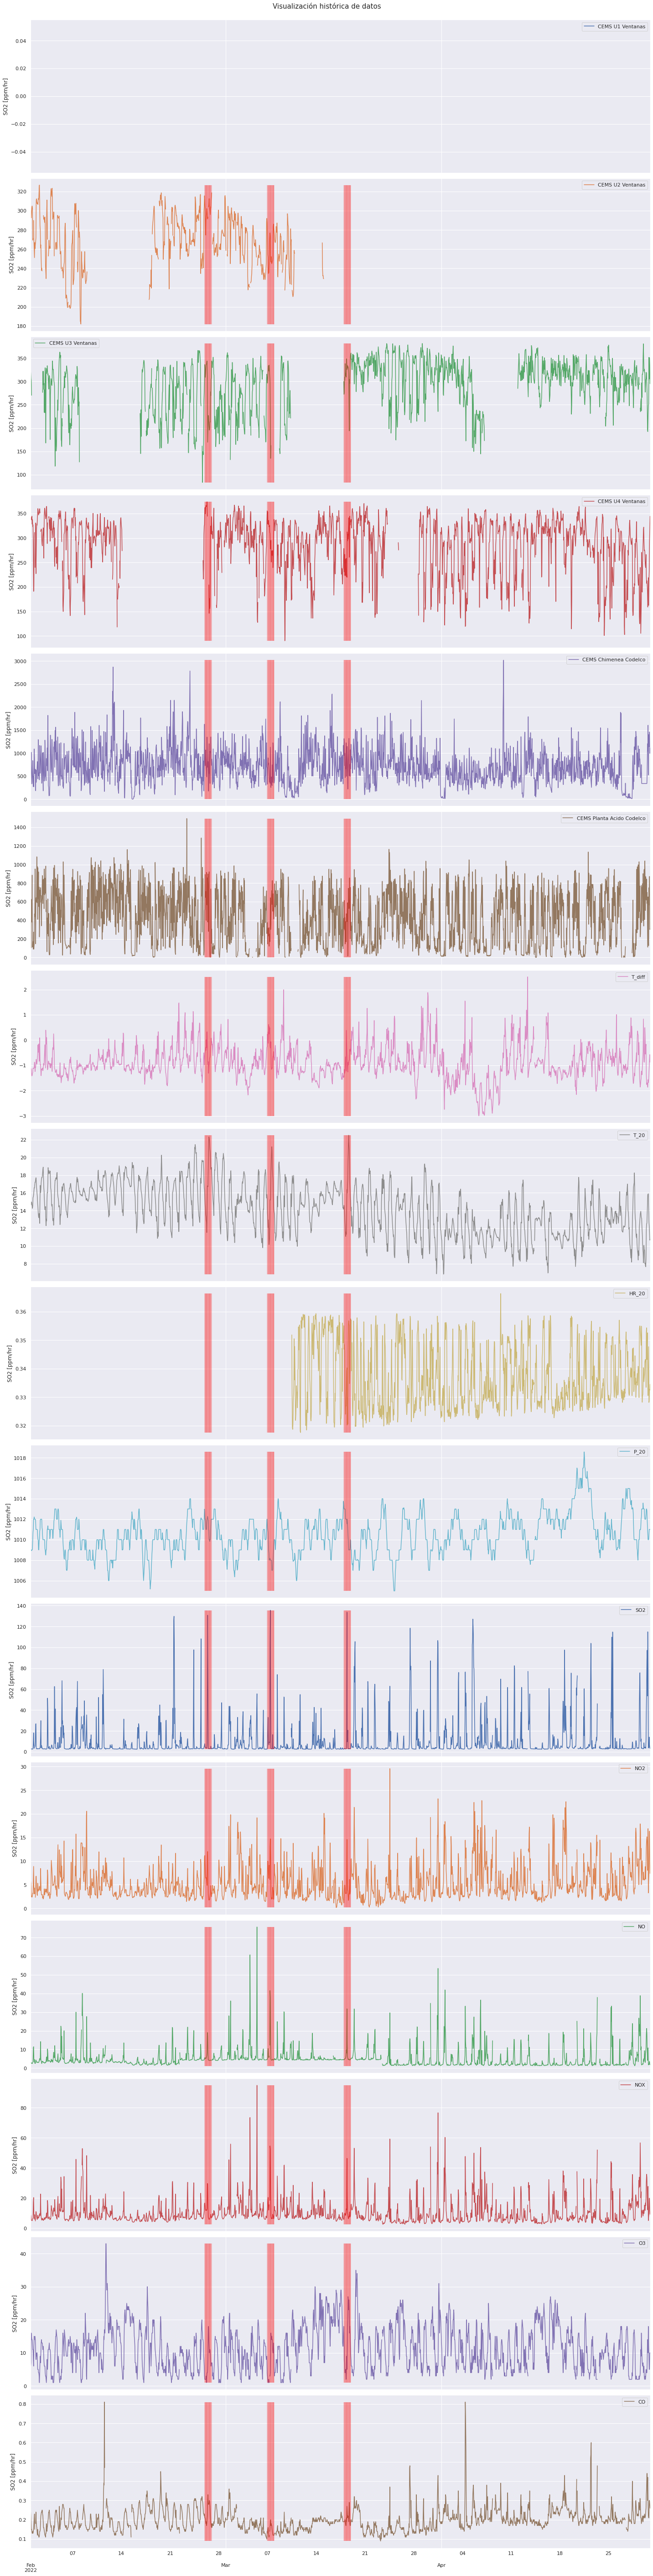

In [14]:
# ylabel_list -> label en eje y para cada variable
series_plot(data_df.loc['2022-02':'2022-04'],
            ylabel_list=['SO2 [ppm/hr]']*data_df.shape[1],
            dates=[pd.date_range(peak,  pd.to_datetime(peak)+pd.Timedelta('23H'), freq='1H') for peak in peak_days])

### Datos nulos

In [ ]:
data_df.isna().sum()

SO2    484
NO2    716
NO     967
NOX    619
O3     493
CO     967
dtype: int64

In [ ]:
(data_df - data_df.mean()) / data_df.std()

,SO2,NO2,NO,NOX,O3,CO
2017-09-06 18:00:00,-0.306546,-0.864559,-0.373597,-0.599024,1.117282,-0.354569
2017-09-06 19:00:00,-0.287500,-0.620920,-0.350816,-0.488018,0.656087,-0.136148
2017-09-06 20:00:00,-0.085934,1.560647,-0.325887,0.377239,-0.727499,0.155080
2017-09-06 21:00:00,-0.138310,1.408653,-0.329153,0.316109,-0.573767,0.082273
2017-09-06 22:00:00,-0.224544,0.266459,-0.338033,-0.134188,-0.112572,0.009466
...,...,...,...,...,...,...
2022-09-06 19:00:00,-0.385902,-0.352695,-0.298675,-0.346772,2.347136,-0.136148
2022-09-06 20:00:00,-0.385373,-0.453279,-0.328037,-0.406806,1.732209,-0.208955
2022-09-06 21:00:00,-0.383786,-0.518101,-0.300314,-0.412083,2.193404,-0.281762
2022-09-06 22:00:00,-0.385373,-0.395164,-0.316046,-0.375309,2.193404,-0.500182


/home/agonzalez/projects/mds7201-minma-so2/src/visualization/eda.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


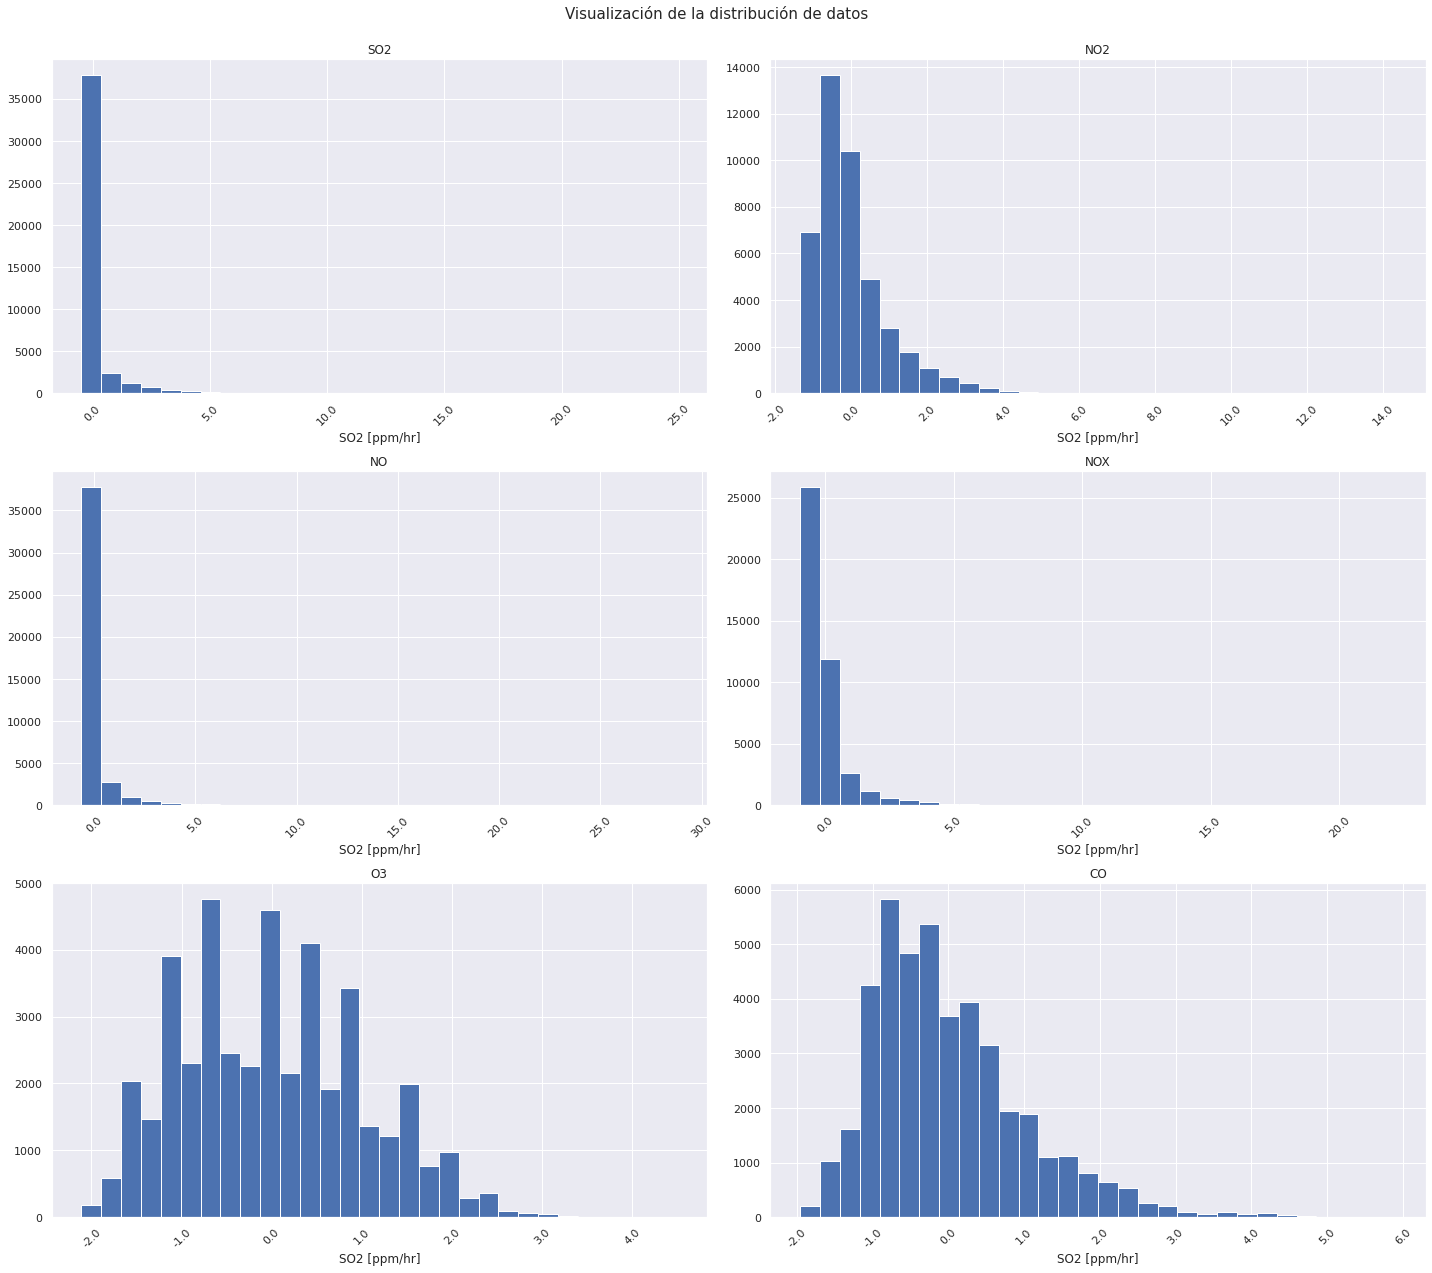

In [ ]:
# xlabel_list -> label en eje x para cada variable
# args = {'xscale':'log', 'yscale':'log'} # -> Descomentar para aplica escala logaritmica 
hist_plot((data_df - data_df.mean()) / data_df.std(), xlabel_list=['SO2 [ppm/hr]']*data_df.shape[1]) #, **args) -> Opcional para escala logaritmica, u otros parámetros

### Resumen estadístico

In [ ]:
data_df.describe()

,CEMS U1 Ventanas,CEMS U2 Ventanas,CEMS U3 Ventanas,CEMS U4 Ventanas,CEMS Chimenea Codelco,CEMS Planta Acido Codelco
count,12388.000000,16786.000000,18760.000000,19586.000000,15021.000000,19703.000000
mean,12.553066,266.664728,267.960240,254.333037,628.224463,359.028793
std,35.598075,62.860692,76.038918,89.209258,447.889732,282.253395
min,0.025691,0.072111,0.000000,0.000000,0.000000,0.000000
25%,1.071545,237.723750,231.588250,216.972250,310.120000,97.883150
50%,1.971170,274.011500,287.927500,279.314500,568.606000,327.583000
75%,3.053872,301.451000,318.527500,315.101500,874.874000,579.797000
max,361.922000,1136.140000,917.834000,1084.550000,3727.310000,1648.650000


### Cantidad de datos por fecha

### Lag plots

#### 1 hora

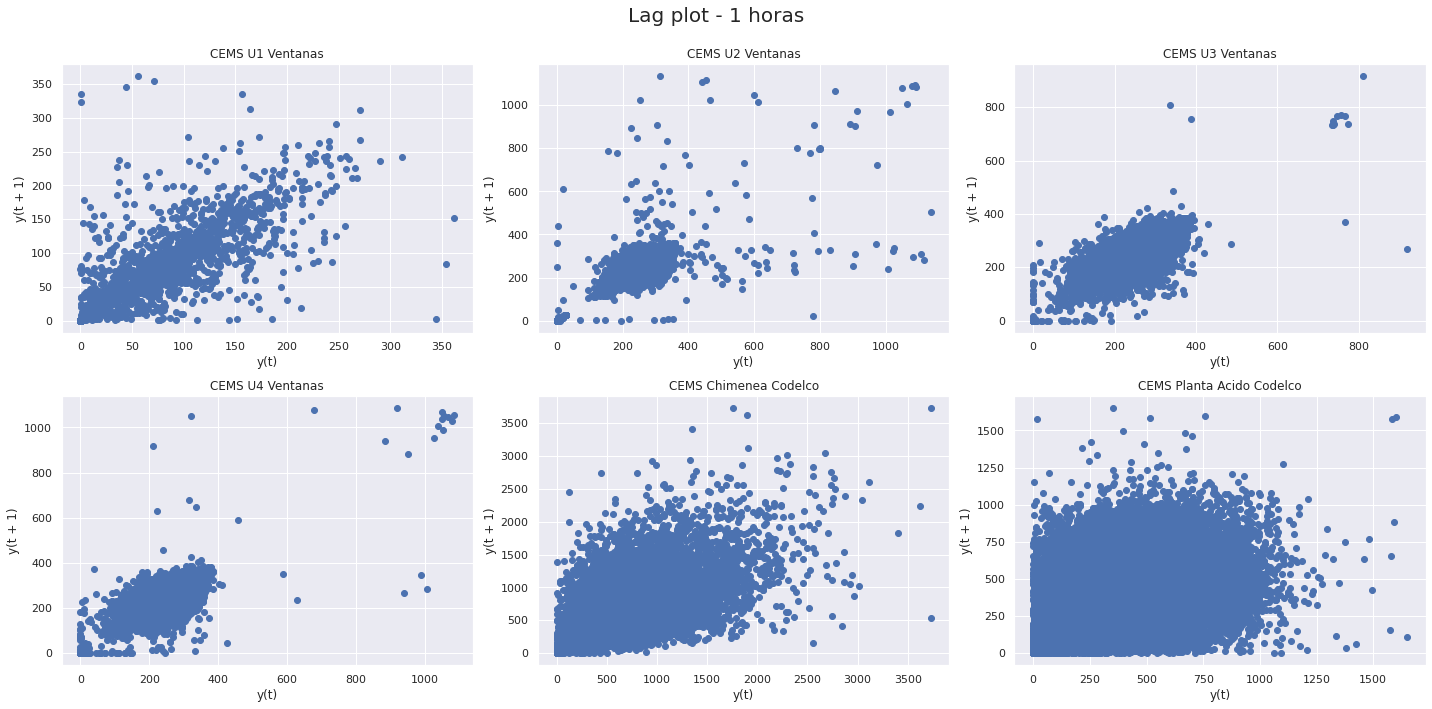

In [ ]:
lag_plot(data_df, lag=1, unit='horas')

#### 1 día

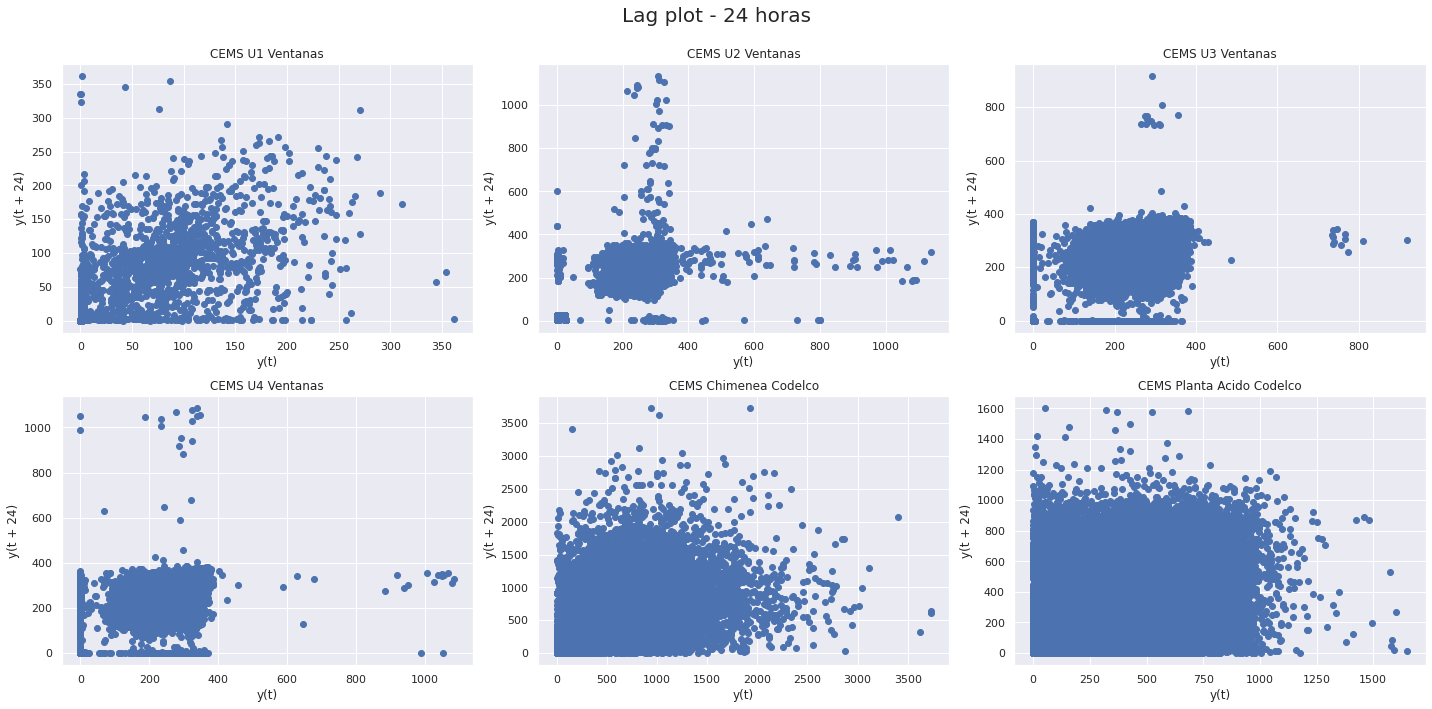

In [ ]:
lag_plot(data_df, lag=24, unit='horas')

### Correlaciones entre datos

#### Pair plot

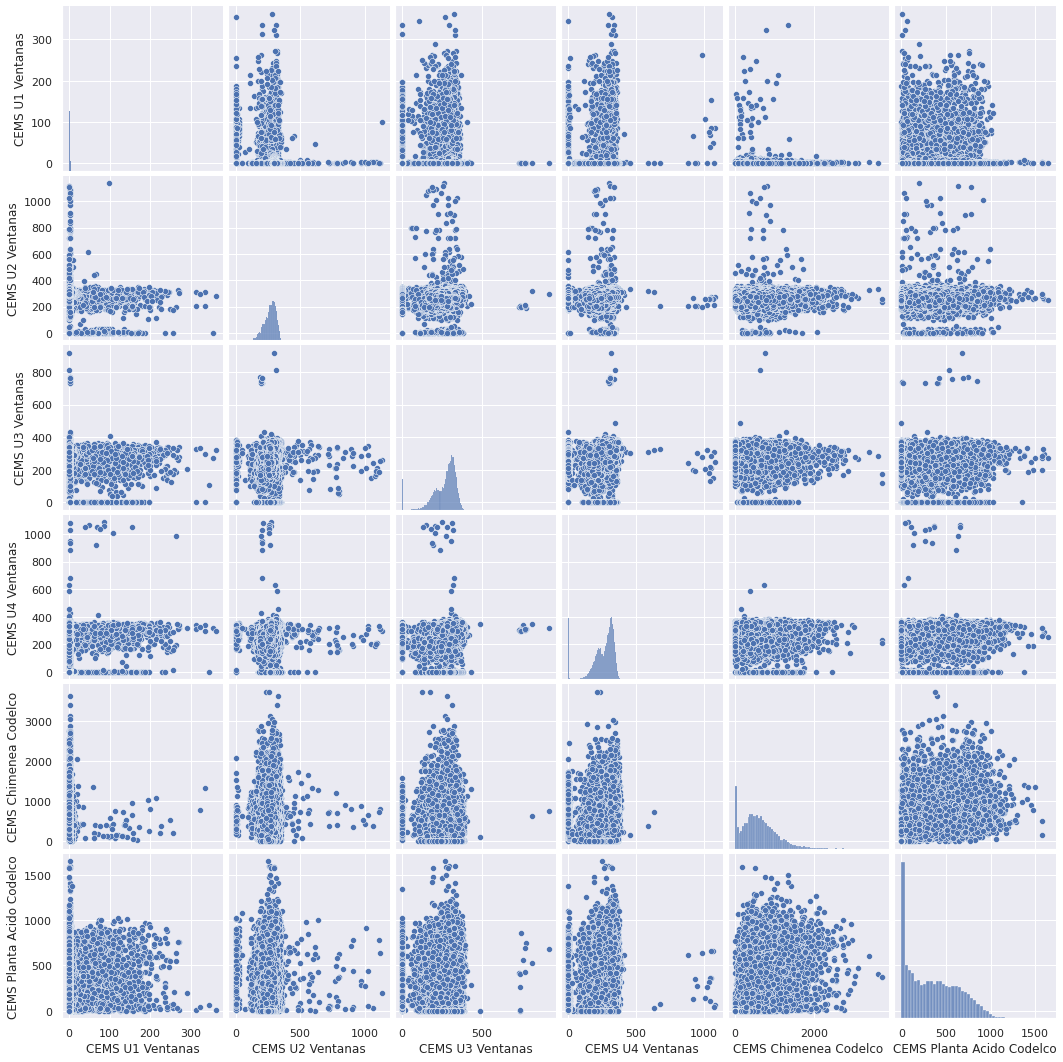

In [ ]:
sns.pairplot(data_df)
plt.show()

#### Matriz de confusion

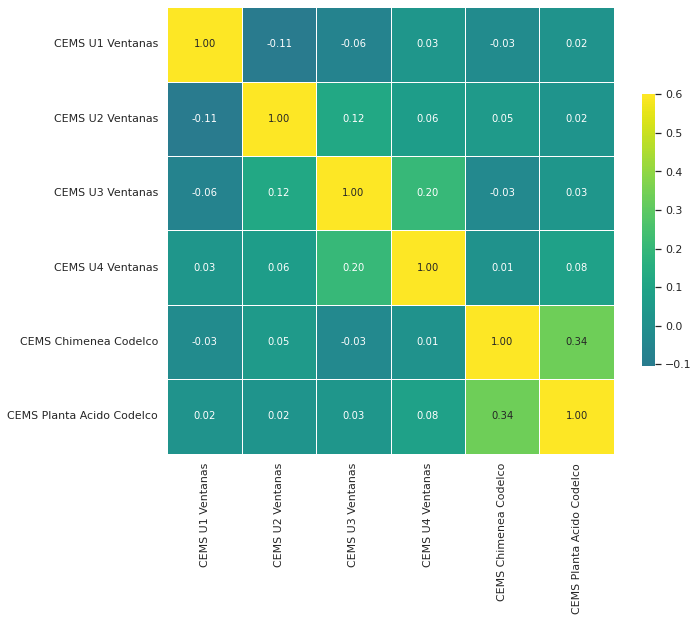

In [ ]:
conf_matrix(data_df)

### Trends

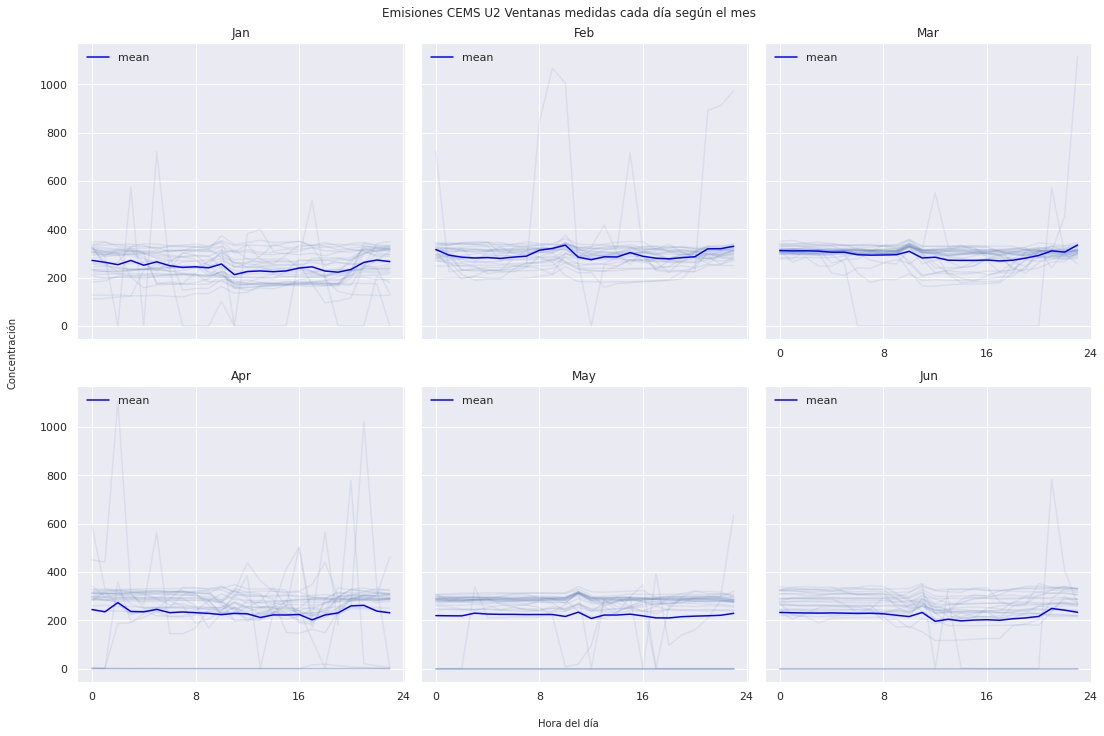

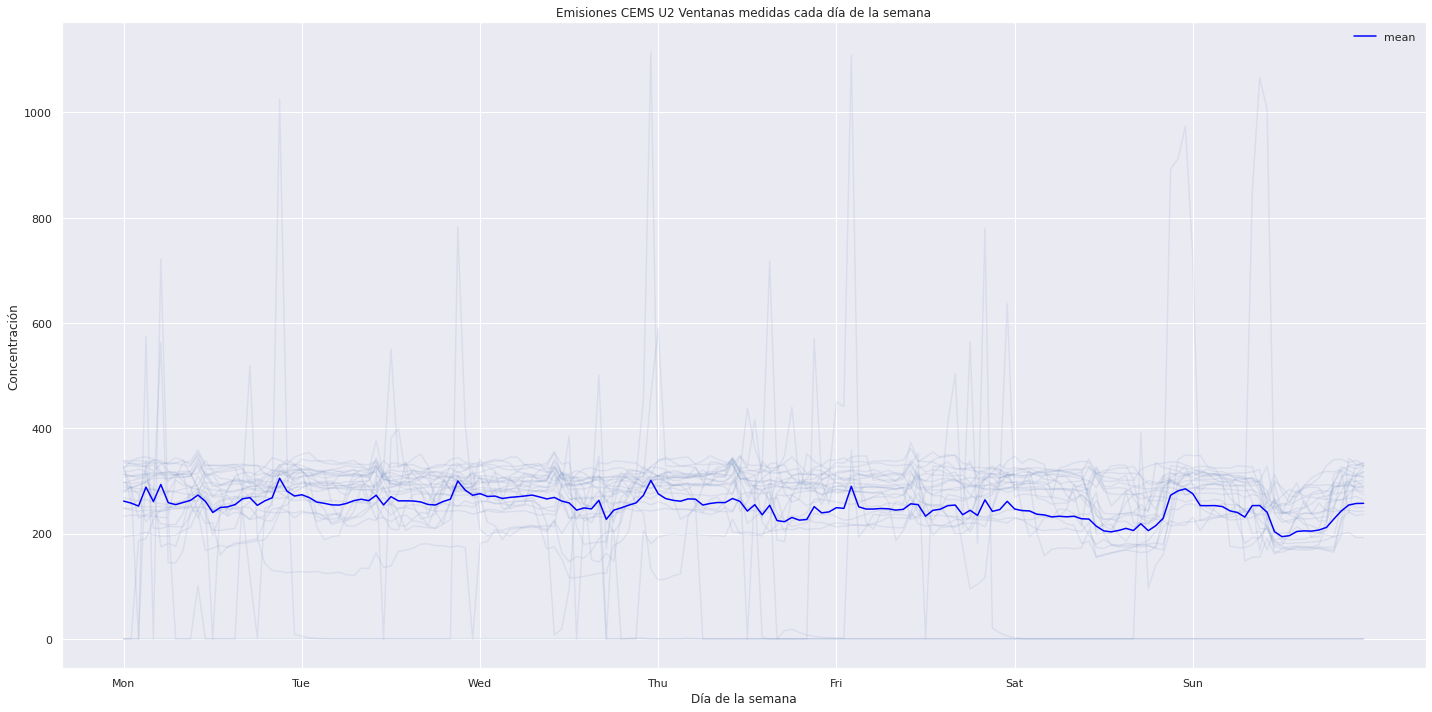

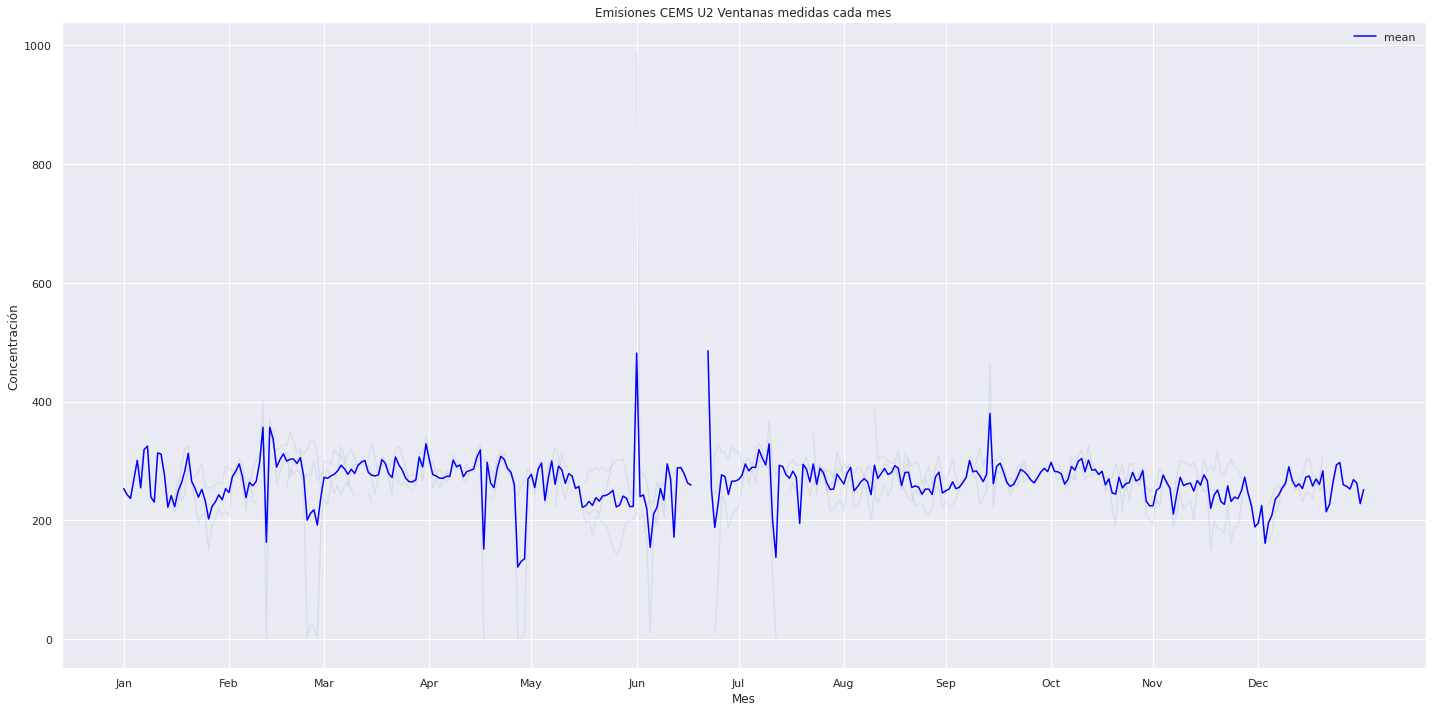

In [ ]:
visualizar_trends(data_df, col = "CEMS U2 Ventanas", ano_0=2021, title='Emisiones CEMS U2 Ventanas')

### Estadísticos por períodos

#### Anual

In [ ]:
time_describe(data_df, col='CEMS U4 Ventanas', res='y', from_date=data_df.index[0], to_date=data_df.index[-1], highlights=True)

#### Mensual

In [ ]:
time_describe(data_df, col='CEMS U4 Ventanas', res='m', from_date=data_df.index[0], to_date=data_df.index[-1])

CEMS U4 Ventanas                                                         \
              count        mean         std       min        25%       50%   
m                                                                            
01            762.0  283.014505   63.982405    0.0000  252.68775  301.2575   
02            832.0  286.173931   49.509554  118.3040  264.09300  299.4370   
03           1932.0  238.381495  131.987433    0.0000  206.02700  288.2625   
04           2150.0  282.810027   47.800879  101.0630  261.99525  295.0975   
05           2214.0  261.219436   60.356314   10.6843  216.24675  277.8520   
06           2123.0  256.252304  108.873173    0.0000  224.63900  290.3020   
07           2058.0  270.031481   72.079516    0.0000  224.35250  288.5760   
08           1892.0  208.072907  112.442806    0.0000  172.90075  225.6135   
09           1448.0  209.704372   97.557150    0.0000  184.45925  224.2545   
10           1315.0  239.754812   67.444587    0.0000  209.69000  249.6600   
11           1395.0  259.613680   71.998410    0.0000  215.78150  262.0290   
12           1465.0  277.246217   58.616607    0.0000  248.57200  293.0440   

                         
          75%       max  
m                        
01  330.18250   369.441  
02  320.10100   373.880  
03  320.18525  1084.550  
04  316.64775   386.019  
05  309.23175   384.421  
06  321.48000  1078.120  
07  326.06950   630.054  
08  305.98475   368.071  
09  277.85500   374.218  
10  287.77400   368.204  
11  316.57900   426.041  
12  315.91000   647.246

#### Diario

In [ ]:
time_describe(data_df, col='CEMS U4 Ventanas', res='d', from_date=data_df.index[0], to_date=data_df.index[-1])

CEMS U4 Ventanas                                                           \
              count        mean         std         min        25%       50%   
d                                                                              
01            665.0  267.641821   91.934847    0.302167  220.45400  274.3190   
02            646.0  259.274973   78.724879    0.000000  215.33700  277.7745   
03            648.0  254.887681   83.664883    0.000000  216.33100  280.2290   
04            647.0  231.053973  101.600477    0.000000  199.77650  259.7090   
05            643.0  239.643288  108.569182    0.000000  205.11600  268.3820   
06            654.0  242.538108  101.569524    0.000000  212.43125  278.3095   
07            642.0  240.162672  102.158867    0.000000  202.15125  270.6300   
08            648.0  251.139371   92.454785    0.000000  218.44575  273.6400   
09            661.0  240.296762  103.213722    0.000000  200.99900  274.6000   
10            647.0  238.840816  111.288951    0.000000  204.86050  278.7120   
11            659.0  245.685051  100.700438    0.000000  214.44150  285.3920   
12            651.0  256.886239   86.395566    0.000000  226.11100  281.2170   
13            648.0  252.340400   83.209714    0.000000  212.70075  277.9425   
14            627.0  268.461877   77.165726    0.000000  236.96400  293.4720   
15            623.0  274.741372  116.564610    0.000000  230.30800  288.5120   
16            622.0  272.939459   73.664393    0.000000  238.90575  297.8175   
17            643.0  266.127793   74.736872    0.000000  225.83400  288.7360   
18            634.0  256.314031   77.365208    0.000000  211.21700  284.4040   
19            650.0  255.007842   81.894323    0.000000  209.58650  284.4350   
20            662.0  247.183424   87.172088    0.000000  213.35025  264.6630   
21            660.0  250.149584   90.284446    0.000000  203.39875  279.8810   
22            661.0  241.715223   92.150787    0.000000  202.02500  264.4370   
23            654.0  232.108293  103.420544    0.000000  193.79275  256.8920   
24            642.0  238.317790  105.255949    0.000000  206.00775  266.2990   
25            618.0  241.380083   97.553195    0.000000  207.50400  269.6525   
26            597.0  268.014621   57.724424    0.000000  222.41800  283.3420   
27            601.0  273.369191   56.444540   45.273900  234.16600  288.9170   
28            621.0  276.922614   49.852502  119.406000  236.79600  289.5840   
29            619.0  272.128843   54.337797   91.498200  237.71750  283.6140   
30            619.0  270.577148   57.438074    7.077500  226.25050  283.3940   
31            374.0  273.420995   56.572960  113.678000  229.82250  286.5510   

                         
          75%       max  
d                        
01  314.46400  1078.120  
02  315.30900   647.246  
03  314.56375   366.065  
04  304.32350   630.054  
05  307.97900  1052.120  
06  315.93050   362.469  
07  314.02400   368.330  
08  320.74125   365.283  
09  317.20400   363.356  
10  321.17600   372.205  
11  315.95600   363.720  
12  316.55800   378.266  
13  310.64550   411.948  
14  320.21200   386.019  
15  319.93950  1084.550  
16  322.04400   368.771  
17  318.75700   367.982  
18  312.79200   355.247  
19  315.62950   365.952  
20  309.75550   384.421  
21  317.31750   365.540  
22  309.56800   385.808  
23  305.75525   589.233  
24  314.41275   377.947  
25  313.40925   367.534  
26  312.79500   373.880  
27  316.87400   426.041  
28  315.27600   365.513  
29  314.35300   369.441  
30  315.10700   373.892  
31  320.04400   361.283

### Clustering

In [ ]:
data_daily = [g for n, g in data_df.groupby(pd.Grouper(freq='D'))]

: 